<a href="https://colab.research.google.com/github/akinyeleolat/pyspark_bid_data_analysis/blob/main/TrySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Update system packages
!sudo apt-get update

#install Java
!sudo apt install default-jdk

# Download Apache Spark and extract
!wget https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xvf spark-3.0.3-bin-hadoop2.7.tgz

#Install pyspark
!pip install -q findspark
!pip install pyspark
!pip install handyspark

# Analysis

In [61]:
#setting the environment path 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
os.environ["PYTHONPATH"] = "%SPARK_HOME%\python;%SPARK_HOME%\python\lib\py4j-0.10.9.2-src.zip:%PYTHONPATH%"
# findspark will locate spark in the system
import findspark
findspark.init()

In [ ]:
#Running a local SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Big Data analytic assignment").getOrCreate()

In [ ]:
spark

In [ ]:
spark.sparkContext

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd
!ls

/content
drive  sample_data  spark-3.0.3-bin-hadoop2.7  spark-3.0.3-bin-hadoop2.7.tgz


In [ ]:
#Replace part of string with another string
from pyspark.sql.functions import *
from pyspark.sql.functions import regexp_replace

#spark data
spark_data = spark.read.format('csv').options(header='true', inferSchema='true').load("/content/drive/MyDrive/uel_dataset/UNSW-NB15.csv").toDF(
    'srcip','sport','dstip','dsport','proto','state','dur','sbytes','dbytes','sttl','dttl','sloss','dloss',
    'service','Sload','dload','Spkts','Dpkts','swin','dwin','stcpb','dtcpb','smeansz','dmeansz','trans_depth','res_bdy_len','Sjit','Djit','Stime','Ltime',
    'Sintpkt','Dintpkt','tcprtt','synack','ackdat','is_sm_ips_ports','ct_state_ttl','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd','ct_srv_src','ct_srv_dst','ct_dst_ltm',
    'ct_src_ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','attack_cat','Label')
spark_data=spark_data.na.fill('Normal',['attack_cat'])
spark_data=spark_data.withColumn('attack_cat', regexp_replace('attack_cat', 'Backdoors', 'Backdoor'))
spark_data=spark_data.withColumn('attack_category', trim(spark_data.attack_cat))
spark_data.show(10, truncate=False)
spark_data.printSchema()

+----------+-----+-------------+------+-----+-----+------------+------+------+----+----+-----+-----+--------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+------------+------------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+---------------+
|srcip     |sport|dstip        |dsport|proto|state|dur         |sbytes|dbytes|sttl|dttl|sloss|dloss|service |Sload    |dload    |Spkts|Dpkts|swin|dwin|stcpb     |dtcpb     |smeansz|dmeansz|trans_depth|res_bdy_len|Sjit     |Djit     |Stime     |Ltime     |Sintpkt     |Dintpkt     |tcprtt      |synack      |ackdat      |is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|

In [ ]:
spark_data.count()

2539738

In [ ]:
from pyspark.sql.functions import col
spark_data.groupBy("attack_category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

In [ ]:
#Summary statics
numeric_features = [t[0] for t in spark_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
num_data_set=spark_data.select(numeric_features)
num_data_set.describe().toPandas().transpose()

In [ ]:
#correlation using vector assembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *

#select only numeric column
numeric_features = [t[0] for t in spark_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
num_data_set=spark_data.select(numeric_features)

assembler = VectorAssembler(inputCols=num_data_set.columns, 
outputCol="features",handleInvalid='keep')


df = assembler.transform(spark_data).select("features")

# correlation will be in Dense Matrix
correlation_matrix = Correlation.corr(df,"features","pearson").collect()[0][0]

# To convert Dense Matrix into DataFrame
rows = correlation_matrix.toArray().tolist()
df = spark.createDataFrame(rows,num_data_set.columns)
df.show(100,truncate=False)


+---------------------+---------------------+----------------------+----------------------+---------------------+---------------------+----------------------+---------------------+----------------------+---------------------+----------------------+---------------------+---------------------+--------------------+---------------------+----------------------+---------------------+----------------------+----------------------+---------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|sport                |dsport               |dur                   |sbytes   

+-----+------+------------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+-------+-------+-----------+-----------+----------+---------+----------+----------+------------+------------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+-----+
|sport|dsport|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    dload|Spkts|Dpkts|swin|dwin|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|     Djit|     Stime|     Ltime|     Sintpkt|     Dintpkt|      tcprtt|      synack|      ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|
+-----+------+------------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+-------+-------+-----------+-----------+---------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff13a973d0>,
      dtype=object)

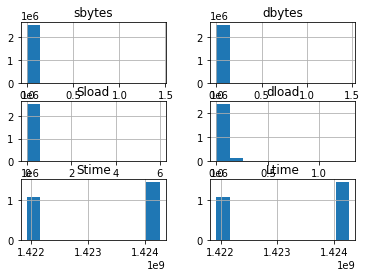

In [ ]:
#Kernel Density Estimation

#Get Random Data
numeric_features = [t[0] for t in spark_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
num_data_set=spark_data.select(numeric_features)

data_set=num_data_set.sample(False, 0.1, seed=0)

data_set.count()

rdd_data = num_data_set.rdd

rdd_data.toDF().show()

# Find density estimates for the given values

rdd_data.toDF().select('sbytes','dbytes','Sload','dload','Stime','Ltime').toPandas().hist()

# rdd_data.toDF().alias("a").select("a.*").toPandas().hist()


# kd = KernelDensity()
# kd.setSample(rdd_data)
# kd.setBandwidth(3.0)


# densities = kd.estimate([])

In [ ]:
# Hypothesis Testing
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import *

#select only numeric column
numeric_features = [t[0] for t in spark_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
num_data_set=spark_data.select(numeric_features)

assembler = VectorAssembler(inputCols=num_data_set.columns, 
outputCol="features",handleInvalid='keep')


df = assembler.transform(spark_data).select("features","Label").sample(False, 0.01, seed=0)

r = ChiSquareTest.test(df, "features","Label").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

Py4JError: ignored

In [ ]:
#Binomial data prepration
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder
stages = []
categoricalColumns = ['attack_category']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )

# stage 1
stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Label', outputCol = 'label')
categ_stringIdx = StringIndexer(inputCol='attack_category', outputCol='catLabel')
# stage 2
stages += [label_stringIdx,categ_stringIdx]

numericCols = ['dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
               'Sload', 'dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'smeansz', 'dmeansz', 'trans_depth',
               'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
               'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
               'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
               'ct_dst_sport_ltm', 'ct_dst_src_ltm']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

print(assemblerInputs)

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
# stage 2
stages += [assembler]
# data_pyspark2=spark_data
# data_pyspark2.printSchema()
print(stages)

Py4JError: ignored

In [ ]:
from pyspark.ml import Pipeline

Binomialdata = spark_data

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(Binomialdata)
Binomialdata = pipelineModel.transform(Binomialdata)
selectedCols = ['attack_category', 'features']
data_pyspark3 = Binomialdata.select(selectedCols)
data_pyspark3.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
#Data training and testing
trainset, testset = data_pyspark3.randomSplit([0.7, 0.3], seed = 2021)
print("Training Dataset Count: " + str(trainset.count()))
print("Test Dataset Count: " + str(testset.count()))

Training Dataset Count: 1777507
Test Dataset Count: 762231


In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(trainset)


In [ ]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))
print("Summary: "+ str(lrModel.summary.accuracy))
print("AreaUnderROC: "+ str(lrModel.summary.areaUnderROC))
print("FalsePositive: "+str(lrModel.summary.falsePositiveRateByLabel))
print("TruePositiveRate: "+str(lrModel.summary.truePositiveRateByLabel))

# We can also use the multinomial family for binary classification
# mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# # Fit the model
# mlrModel = mlr.fit(training)

# # Print the coefficients and intercepts for logistic regression with multinomial family
# print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
# print("Multinomial intercepts: " + str(mlrModel.interceptVector))

Coefficients: [-1.409669514560993,1.3447919814611775,1.252492873132705,1.2400003805255735,1.2385976957390779,1.2366216304085604,1.2331032772036206,1.2319519211700876,1.2314851033512977,1.2314984525416142,1.2312811714917595,1.230917283416855,1.2307605706872649,-5.5030659910054065e-06,6.567355173329582e-05,8.881047484635294e-08,-2.2049908228190599e-07,0.005673056222687562,0.0014583225938561222,-0.0009473333241336409,-0.0007967621765643826,7.572927432961397e-10,-2.436053332049977e-08,-0.0007563607872110511,-0.00044877019954735626,-0.0011780379127343328,-0.001173080493765644,-0.00020263726147727967,-0.00038022223853308716,-0.050229847727867656,-2.6768980259822555e-07,5.526353458623824e-07,-7.611394236838304e-06,-1.2518077561423313e-09,-1.2518123612593322e-09,-3.226995332861935e-06,-3.596998263547141e-06,1.4637655977280104,2.2541373631806323,2.8408700892914958,-0.1785453531442562,0.5996088918587519,-0.021892061101590754,-0.11166072454080102,-0.07548612574769278,0.01656719064957256,0.0167373

In [ ]:
lrFinal=lrModel.transform(testset)

In [ ]:
#predictions
lrFinal.select('prediction','probability').show(20, truncate=False)

+----------+-----------------------------------------+
|prediction|probability                              |
+----------+-----------------------------------------+
|0.0       |[0.999116704824879,8.832951751209612E-4] |
|0.0       |[0.9990813463046534,9.186536953465563E-4]|
|0.0       |[0.9991341630880507,8.658369119492814E-4]|
|0.0       |[0.9991325683444163,8.674316555837312E-4]|
|0.0       |[0.999165564833141,8.344351668589152E-4] |
|0.0       |[0.9990624247465106,9.375752534893575E-4]|
|0.0       |[0.9992578545962075,7.421454037924532E-4]|
|0.0       |[0.9992268355096934,7.73164490306656E-4] |
|0.0       |[0.9991510905931149,8.489094068851362E-4]|
|0.0       |[0.9990064924424268,9.935075575731441E-4]|
|0.0       |[0.9991665612224682,8.334387775317912E-4]|
|0.0       |[0.9992262645610762,7.737354389238486E-4]|
|0.0       |[0.9992136972933979,7.86302706602169E-4] |
|0.0       |[0.9990435104454689,9.56489554531014E-4] |
|0.0       |[0.9991800793839771,8.199206160228999E-4]|
|0.0      

In [ ]:
predictions=lrFinal
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(52,[0,13,14,15,1...|[7.03096744105127...|[0.99911670482487...|       0.0|
|  0.0|(52,[0,13,14,15,1...|[6.99168225840662...|[0.99908134630465...|       0.0|
|  0.0|(52,[0,13,14,15,1...|[7.05094777855588...|[0.99913416308805...|       0.0|
|  0.0|(52,[0,13,14,15,1...|[7.04910602434347...|[0.99913256834441...|       0.0|
|  0.0|(52,[0,13,14,15,1...|[7.08792072538071...|[0.99916556483314...|       0.0|
|  0.0|(52,[0,13,14,15,1...|[6.97127551790047...|[0.99906242474651...|       0.0|
|  0.0|(52,[0,13,14,15,1...|[7.20522295108047...|[0.99925785459620...|       0.0|
|  0.0|(52,[0,13,14,15,1...|[7.16424527377371...|[0.99922683550969...|       0.0|
|  0.0|(52,[0,13,14,15,1...|[7.07070881308307...|[0.99915109059311...|       0.0|
|  0.0|(52,[0,13

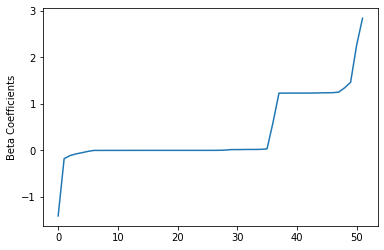

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

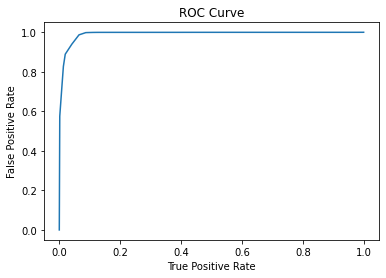

Training set areaUnderROC: 0.9911682209381297


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

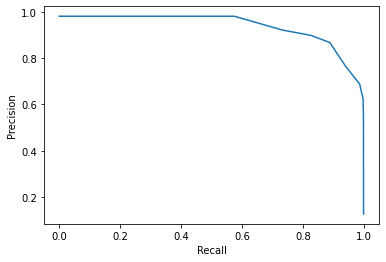

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9914930920233909


In [ ]:
#Multiclass Binary classifier
from pyspark.ml import Pipeline

Binomialdata = spark_data

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(Binomialdata)
Binomialdata = pipelineModel.transform(Binomialdata)
selectedCols = ['catLabel','attack_cat', 'features']
data_pyspark5 = Binomialdata.select(selectedCols)
data_pyspark5.printSchema()

root
 |-- catLabel: double (nullable = false)
 |-- attack_cat: string (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
#Data training and testing
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import *
import pyspark.sql.functions as F

trainset, testset = data_pyspark5.randomSplit([0.7, 0.3], seed = 2021)
print("Training Dataset Count: " + str(trainset.count()))
print("Test Dataset Count: " + str(testset.count()))

Training Dataset Count: 1777507
Test Dataset Count: 762231


In [ ]:
from pyspark.ml.classification import LogisticRegression
mlr = LogisticRegression(featuresCol = 'features', labelCol = 'catLabel', maxIter=10)
mlrModel = mlr.fit(trainset)

In [ ]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(mlrModel.coefficientMatrix))
print("Intercept: " + str(mlrModel.interceptVector))

trainingSummary = mlrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Coefficients: 
DenseMatrix([[ 9.23200461e-01, -8.80699925e-01, -8.20307925e-01,
              -8.12136786e-01, -8.11170239e-01, -8.09854022e-01,
              -8.07561909e-01, -8.06823663e-01, -8.06542204e-01,
              -8.06535772e-01, -8.06384602e-01, -8.06152813e-01,
              -8.06052810e-01,  3.60447577e-06, -4.63131343e-05,
              -5.41783754e-08,  1.43660499e-07, -3.71550402e-03,
              -9.55817843e-04,  5.79838678e-04,  5.18444472e-04,
              -4.97691519e-10,  1.59540195e-08,  4.83766316e-04,
               2.92219762e-04,  7.71327301e-04,  7.68080493e-04,
               1.33149330e-04,  2.49114090e-04,  2.85136568e-02,
               1.79575068e-07, -3.76072525e-07,  4.95888299e-06,
               1.63902166e-09,  1.63902445e-09,  2.09282483e-06,
               2.30115875e-06, -9.58983059e-01, -1.47913650e+00,
              -1.85502727e+00,  1.16930056e-01, -3.92331440e-01,
               1.45658961e-02,  7.25349568e-02,  4.91300637e-02,
          

In [ ]:
mlrFinal=mlrModel.transform(testset)

In [ ]:
predictions = mlrFinal
predictions.filter(predictions['prediction'] == 0) \
    .select("attack_cat","catLabel","probability","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 100, truncate = 30)

+----------+--------+------------------------------+----------+
|attack_cat|catLabel|                   probability|prediction|
+----------+--------+------------------------------+----------+
|       DoS|     4.0|[0.9999125604795457,5.68650...|       0.0|
|    Normal|     0.0|[0.9996679459352167,2.92660...|       0.0|
|   Generic|     1.0|[0.9996281872448562,1.80605...|       0.0|
|    Normal|     0.0|[0.9996204470904078,8.92102...|       0.0|
|       DoS|     4.0|[0.9995819884163311,6.31320...|       0.0|
|    Normal|     0.0|[0.9994816912723931,2.51983...|       0.0|
|    Normal|     0.0|[0.9992306805697242,1.91324...|       0.0|
|    Normal|     0.0|[0.9992306805697242,1.91324...|       0.0|
|    Normal|     0.0|[0.9991944516453465,2.49535...|       0.0|
|    Normal|     0.0|[0.9991944516453465,2.49535...|       0.0|
|       DoS|     4.0|[0.9990499248231633,4.23520...|       0.0|
|    Normal|     0.0|[0.9987662643013405,3.61018...|       0.0|
|    Normal|     0.0|[0.9987604402499274

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol = 'catLabel', predictionCol="prediction")
evaluator.evaluate(predictions)

0.9204989204255896